In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from tensorflow.keras.models import Sequential
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import STOPWORDS, WordCloud

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Competition description
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. 

Submissions are evaluated using F1 between the predicted and expected answers.

## Exploratory Data Analysis

In [98]:
df_train = pd.read_csv("train.csv", encoding="utf-8")
df_test = pd.read_csv("test.csv", encoding="utf-8")
print(df_train.shape, df_test.shape)

(7613, 5) (3263, 4)


In [99]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [100]:
# Check for NaN count

print("Training data:")
for column in df_train.columns:
    missing = df_train[column].isna().sum()
    print(column, missing, round(missing / len(df_train) *100, 2))
print("Testing data")
for column in df_test.columns:
    missing = df_test[column].isna().sum()
    print(column, missing, round(missing / len(df_train) *100, 2))

Training data:
id 0 0.0
keyword 61 0.8
location 2533 33.27
text 0 0.0
target 0 0.0
Testing data
id 0 0.0
keyword 26 0.34
location 1105 14.51
text 0 0.0


Per observation, the amount of missing values in `location` column is significant. Therefore it should not be used as any feature for training.

In [101]:
df_train["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

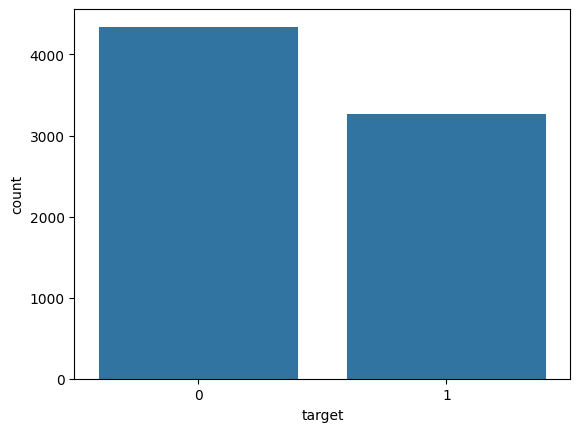

In [102]:
sns.barplot(df_train["target"].value_counts())

Per observation, this dataset provides a good balance between the number of positive and negative samples. Therefore, the dataset does not require any resampling.

The problem becomes a simple binary classification.

Word distribution by WordCloud

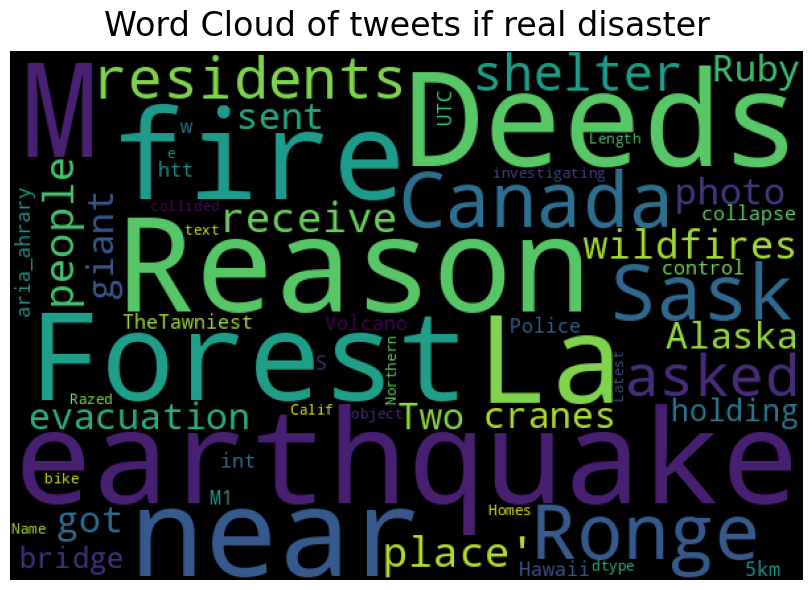

In [103]:
## https://www.kaggle.com/aashita/word-clouds-of-various-shapes
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,6.0), 
                   title = None, title_size=24, image_color=False):
    # Set stopwords
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    # Create wordcloud
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=600, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()  
    
    
plot_wordcloud(df_train[df_train["target"]==1]['text'], title="Word Cloud of tweets if real disaster")

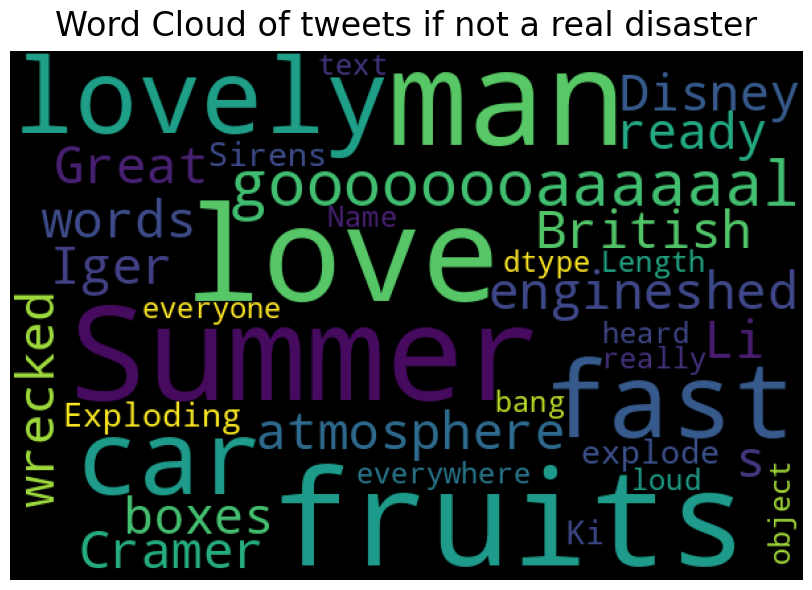

In [104]:
plot_wordcloud(df_train[df_train["target"]==0]['text'], title="Word Cloud of tweets if not a real disaster")

Comparing the above 2 word clouds, we can see that the distribution of words in the disaster tweets is different from the distribution of words in the non-disaster tweets. Some words like "exploding" and "wrecked" which seems like a disaster keyword, doesn't appear in the real disaster tweet at all. This is a good sign that we can build a model to classify the tweets.

Text(0.5, 0.98, 'Average word length in each tweet')

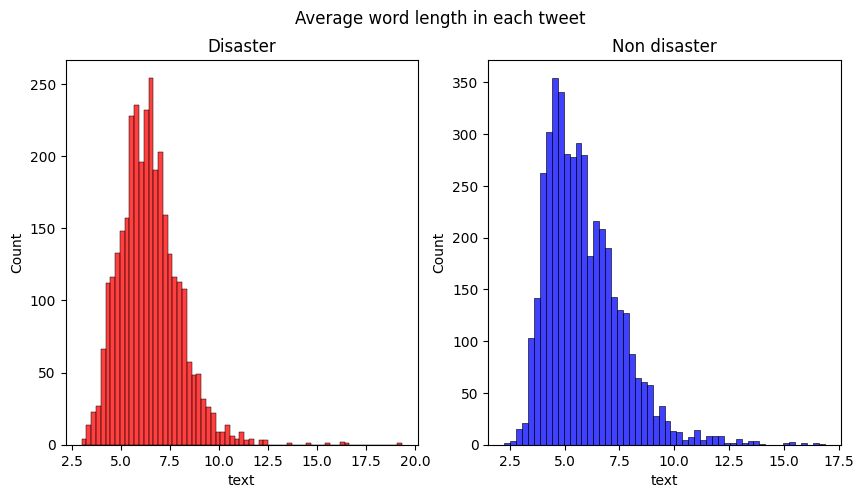

In [105]:
# Average word length in a tweet, disaster vs non disaster

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Disaster')
word = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

Per observation you can see that the distribution of the number of words in the tweet is different between the disaster and non-disaster tweets. The disaster tweets tend to have more words than the non-disaster tweets.

## Word processing

In this process we are going to remove the stopwords, punctuations, and URLs from the tweets. We are also going to convert the words to lowercase.

### Stemming vs Lemmatization

Stemming and Lemmatization are the process of reducing a word to its base form. The difference is that stem might not be an actual word whereas, lemma is an actual language word. For example, the word "running" will be reduced to "run" by stemming and "running" by lemmatization. Lemmatization is computationally expensive compared to stemming but it is more accurate.
In our case, we are going to use lemmatization since the dataset is not very large.

In [106]:
# Words cleaning

def clean_text(text):
    # Clear the text from symbols and links
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    # Clear the text from emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Clear the text from stopwords
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    
    # Lemmatize the text
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])
    
    return text

df_train['text_clean'] = df_train['text'].apply(lambda x: clean_text(x))

df_train['text_clean'].head()

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3     people receive wildfire evacuation order cali...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text_clean, dtype: object

## New visualization on word count, after cleaning the text

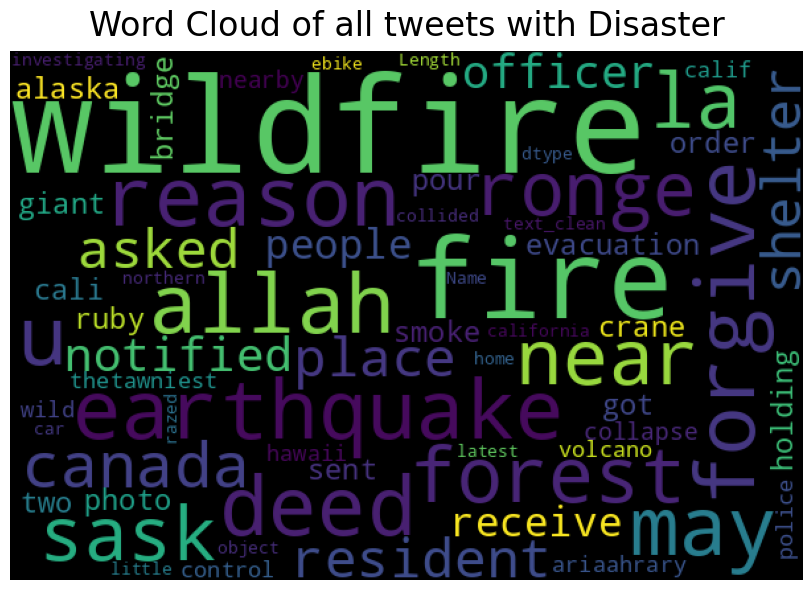

In [107]:
# Wordcount graph

plot_wordcloud(df_train[df_train["target"]==1]['text_clean'], title="Word Cloud of all tweets with Disaster")

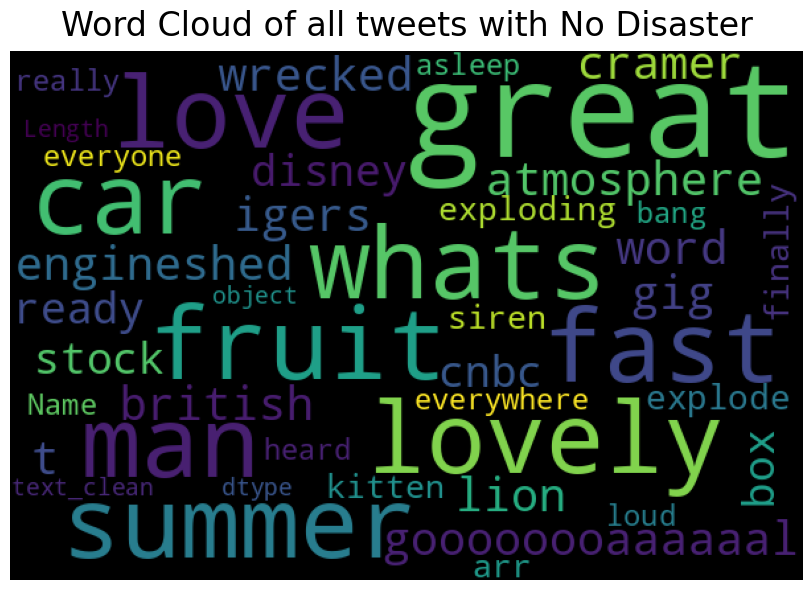

In [118]:
plot_wordcloud(df_train[df_train["target"]==0]['text_clean'], title="Word Cloud of all tweets with No Disaster")

### Display top 10 words from each category

<Axes: title={'center': 'Top 15 words in disaster tweets'}, xlabel='text'>

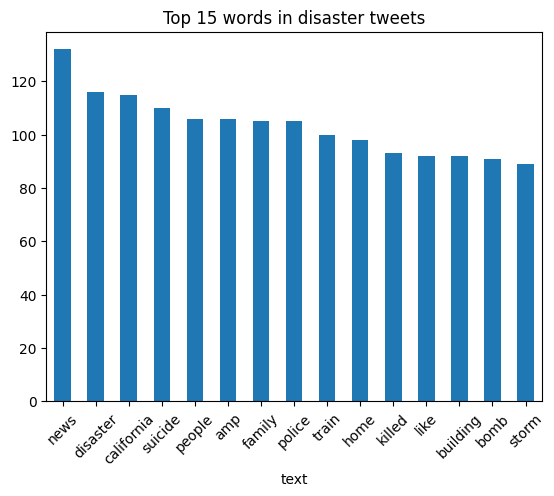

In [129]:
# top 10 words from disaster and non disaster tweets plot

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_train[df_train['target']==1]['text_clean'], 15)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 15 words in disaster tweets', rot=45)



<Axes: title={'center': 'Top 15 words in non disaster tweets'}, xlabel='text'>

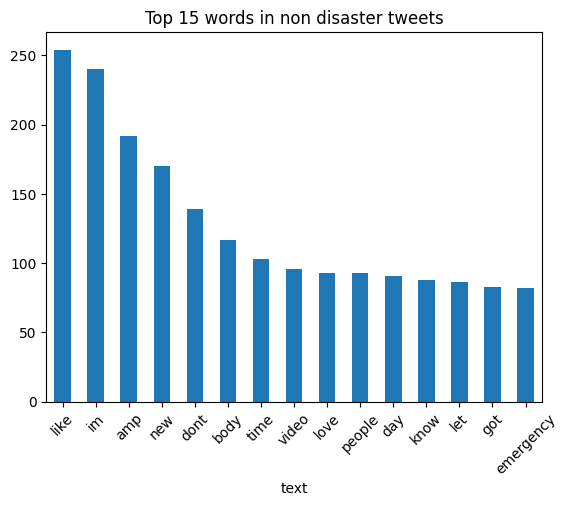

In [130]:
common_words = get_top_n_words(df_train[df_train['target']==0]['text_clean'], 15)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 15 words in non disaster tweets', rot=45)

Per inspection, the top 15 words in the disaster tweets are way different from the top 15 words in the non-disaster tweets. 

Also from the word count, the common words like "the", "a", "in" are not in the top 15 words. 

This is a good sign that we can build a model to classify the tweets.

## Embedding

In this process, we are going to convert the words into vectors. We are going to use the GloVe pre-trained word vectors.

In [ ]:
# Use GloVe for word embeddings

def create_corpus(df):
    corpus=[]
    for tweet in df['text_clean'].str.split():
        for word in tweet:
            corpus.append(word)
    return corpus

corpus=create_corpus(df_train)

# GloVe embeddings
embedding_dict={}
with open('glove.6B.100d.txt','r', encoding="utf-8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

# Check coverage of GloVe embeddings
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
    print(f'Found embeddings for {len(known_words)} words ({nb_known_words} in vocab)')
    print(f'Missing embeddings for {len(unknown_words)} words ({nb_unknown_words} in vocab)')
    return unknown_words

vocab = Counter(corpus)
oov = check_coverage(vocab, embedding_dict)


Found embeddings for 10430 words (61448 in vocab)
Missing embeddings for 5003 words (6473 in vocab)


## Model selection
For this project purpose, we will use 2 types of models:
1. LSTM/GRU Neural Network
2. BERT - Transformer model

According to my research, comparing the 2 models:
1. LSTM/GRU Neural Network
    - Pros: 
        - Easy to implement
        - Fast training
    - Cons:
        - Not as accurate as BERT
        - Not able to capture the context of the words
2. BERT - Transformer model
    - Pros:
        - State of the art model
        - Able to capture the context of the words
    - Cons:
        - Slow training
        - Requires a lot of computational power

Therefore, in this project, my goal is to compare the accuracy of the 2 models.
Also under the limited computational power of my personal computer, is it possible for BERT to outperform the LSTM/GRU model?

In [110]:
df_train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [111]:
# Tokenization
word_tokenizer = Tokenizer()

df_train['text_tokenized'] = df_train['text'].copy()
word_tokenizer.fit_on_texts(df_train['text_tokenized'])
X = word_tokenizer.texts_to_sequences(df_train['text_tokenized'])
X = pad_sequences(X)
X

array([[    0,     0,     0, ...,  4634,    89,    40],
       [    0,     0,     0, ...,  6954,  6955,  1404],
       [    0,     0,     0, ...,  1405,    24,  1106],
       ...,
       [    0,     0,     0, ...,     1,     2,  6913],
       [    0,     0,     0, ...,   131,  2048,   316],
       [    0,     0,     0, ...,     1,     2, 22700]], dtype=int32)

GloVe (Global Vectors for Word Representation): GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Source: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt

In [112]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [113]:
vocab_length = len(word_tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [114]:
y = df_train['target'].values

# Split df_train into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
# Find the longest sentence length
length_long_sentence = len(X_train[0])
for i in X_train:
    if len(i) > length_long_sentence:
        length_long_sentence = len(i)
print(length_long_sentence)

33


In [116]:
# Create the LSTM model
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = BLSTM()
model.summary()

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     2,270,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,100 (8.66 MB)

 Trainable params: 2,270,100 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

## Model evaluation

NameError: name 'history' is not defined

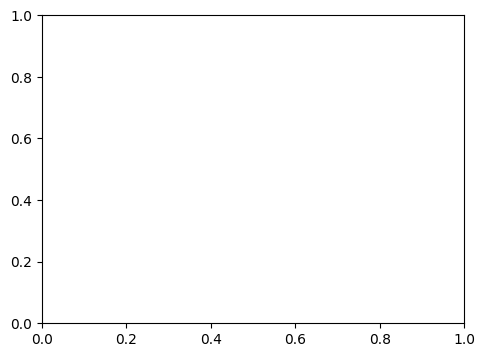

In [117]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7442 - loss: 1.0914
Loss: 0.993323564529419
Accuracy: 0.7623112201690674


In [ ]:
preds = model.predict(X_test)

print("F1-score: ", f1_score(preds, y_test))
print("Precision: ", precision_score(preds, y_test))
print("Recall: ", recall_score(preds, y_test))
print("Acuracy: ", accuracy_score(preds, y_test))

print(classification_report(preds, y_test))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


ValueError: Classification metrics can't handle a mix of continuous and binary targets